In [0]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [0]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [0]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input,LSTM,Embedding,Dense,Concatenate,TimeDistributed,Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings 
pd.set_option("display.max_colwidth",200)
warnings.filterwarnings("ignore")



Using TensorFlow backend.


In [0]:
data=pd.read_csv("/content/drive/My Drive/dataset/iit delhi/tourist_summary_data.csv")
#200000 over here is to only include 200000 raw data from total data


In [0]:
len(data)

78322

In [0]:
data[:5]

,Unnamed: 0,comment,summary
0,3,august today precious day someone special born fight sin save trust god something unexplainably lovely small hill towns one ventured will surely relate dreaming waking beautiful mesmerizing vi...,august chicago cubs game heart pendant baseball jewelry organise separate commemorative programmes remembrance martyrs infamous took place august party flags events
1,4,study suggests migration rural areas rural areas plain districts state uttarakhand largely problem perception little geographical realities devi great gift idea chicago cubs game baseball jewle...,study suggests migration rural areas rural areas plain districts state uttarakhand largely problem perception little geographical realities absolute king makes skin crawl kept smh
2,5,activate option huge disappointment plate year chances pastseasons little production sad albert point tough decisions made temple kosi katarmal district almora bloop rbi single ends third thro...,activate option beautiful click credits deepak instagram thanks sharing sir know parents side amazing story
3,6,agree season long slump will ever get another hit disappointing plate fouls end inning leave couple plateand now tied mid infield knock hill locally known jhandi dhar offers panoramic view kum...,agree season long slump will ever get another hit disappointing plate triambkeshwar shiva temple night many balls going drop tonight
4,7,dunagiri temple temple vlog shining souls required medical practitioner like free medical health camp project working support incomes non farm livelihoods strengthen food production system said...,dunagiri temple temple vlog nice running catch end inning leading ncc


In [0]:
data.drop_duplicates(subset=['comment'],inplace=True)
data.dropna(axis=0,inplace =True)

In [0]:
#creatin dictionary fro expanding contractions
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
stop_words=set(stopwords.words('english'))

In [0]:
TEXT_CLEANING_RE="@\S+|https?:\S+|http?:\S\[^A-Za-z0-9]+"
def preprocessing(text):
    newstring=text.lower()
    newstring=BeautifulSoup(newstring,'lxml').text#to get text from html and xml pages
    newstring=re.sub(TEXT_CLEANING_RE,'',newstring)
    newstring = re.sub(r'\([^)]*\)', '', newstring)
    newstring=re.sub('"','',newstring)
    newstring=re.sub(r"'s\b","",newstring)
    newstring=re.sub("[^a-zA-Z]", " ", newstring)
    word=[]
    for i in newstring.split():
        if i in contraction_mapping:
            word.append(contraction_mapping[i])
        else:
            word.append(i)
    
    newstring=' '.join(word)
    
    wordb=[]
    for i in newstring.split():
        if i not in stop_words:
            wordb.append(i)
    
    fword=[]
    
    for i in wordb:
        if len(i)>=3:
            fword.append(i)
    
    return " ".join(fword).strip()



            
    
    

In [0]:
#making a new array of cleaned text

cleaned_text=data.comment.apply(lambda x :preprocessing(x))

In [0]:
cleaned_text[:5]

0    august today precious day someone special born fight sin save trust god something unexplainably lovely small hill towns one ventured surely relate dreaming waking beautiful mesmerizing view mounta...
1    study suggests migration rural areas rural areas plain districts state uttarakhand largely problem perception little geographical realities devi great gift idea chicago cubs game baseball jewlery ...
2    activate option huge disappointment plate year chances pastseasons little production sad albert point tough decisions made temple kosi katarmal district almora bloop rbi single ends third throwing...
3    agree season long slump ever get another hit disappointing plate fouls end inning leave couple plateand tied mid infield knock hill locally known jhandi dhar offers panoramic view kumaon hills gre...
4    dunagiri temple temple vlog shining souls required medical practitioner like free medical health camp project working support incomes non farm livelihoods strengthen food prod

In [0]:
#cleaning summary
cleaned_summary=data.summary.apply(lambda x :preprocessing(x))

In [0]:
cleaned_summary.replace('',np.nan,inplace=True)

In [0]:

cleaned_summary[:5]
# np.dtype(cleaned_summary)

0                   august chicago cubs game heart pendant baseball jewelry organise separate commemorative programmes remembrance martyrs infamous took place august party flags events
1    study suggests migration rural areas rural areas plain districts state uttarakhand largely problem perception little geographical realities absolute king makes skin crawl kept smh
2                                                                            activate option beautiful click credits deepak instagram thanks sharing sir know parents side amazing story
3                                                        agree season long slump ever get another hit disappointing plate triambkeshwar shiva temple night many balls going drop tonight
4                                                                                                                  dunagiri temple temple vlog nice running catch end inning leading ncc
Name: summary, dtype: object

In [0]:
type(data)

pandas.core.frame.DataFrame

In [0]:
#defining function to add start and end word in summary

def addstartend(text):
    k='_START_'+str(text)+'_END_'
    return k

In [0]:
cleaned_summary=cleaned_summary.apply(lambda x:addstartend(x))

In [0]:
cleaned_summary[:5]

0                   _START_august chicago cubs game heart pendant baseball jewelry organise separate commemorative programmes remembrance martyrs infamous took place august party flags events_END_
1    _START_study suggests migration rural areas rural areas plain districts state uttarakhand largely problem perception little geographical realities absolute king makes skin crawl kept smh_END_
2                                                                            _START_activate option beautiful click credits deepak instagram thanks sharing sir know parents side amazing story_END_
3                                                        _START_agree season long slump ever get another hit disappointing plate triambkeshwar shiva temple night many balls going drop tonight_END_
4                                                                                                                  _START_dunagiri temple temple vlog nice running catch end inning leading ncc_END_
Name: summary, 

In [0]:
len(cleaned_summary)

78297

to save cleaned text/summary

In [0]:
cleaned_summary.to_csv('/content/drive/My Drive/dataset/iit delhi/cleansummary_startend_data.csv')

In [0]:
len(cleaned_text)

78297

In [0]:
type(cleaned_text)

pandas.core.series.Series

In [0]:
cleaned_text.to_csv('/content/drive/My Drive/dataset/iit delhi/cleantext_startend_data.csv')

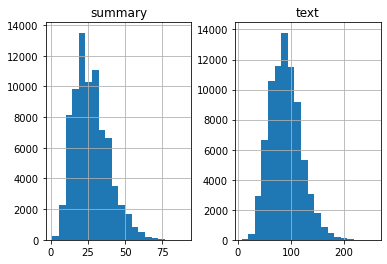

In [0]:
#counting number of words to get padding
import matplotlib.pyplot as plt
text_word_count=[]
for i in cleaned_text:
    text_word_count.append(len(i.split()))
    
summary_word_count=[]
for i in cleaned_summary:
    summary_word_count.append(len(i.split()))
    
length_df=pd.DataFrame({'text':text_word_count,'summary':summary_word_count})
length_df.hist(bins=20)
plt.show()

In [0]:
max_len_text=200
max_len_summary=70

In [0]:
#splitting data for train and validation
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(cleaned_text,cleaned_summary,test_size=.1,random_state=0,shuffle=True)

In [0]:
print(len(x_tr))
print(len(y_tr))
print(len(x_val))
print(len(y_val))

70467
70467
7830
7830


In [0]:
x_tr.to_csv('/content/drive/My Drive/dataset/iit delhi/x_train.csv')
x_val.to_csv('/content/drive/My Drive/dataset/iit delhi/x_val.csv')
y_tr.to_csv('/content/drive/My Drive/dataset/iit delhi/y_train.csv')
y_val.to_csv('/content/drive/My Drive/dataset/iit delhi/y_val.csv')

In [0]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(x_tr)


x_voc_size   =  len(x_tokenizer.word_index) +1

In [0]:
#preparing a tokenizer for summary on training data 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))


y_voc_size  =   len(y_tokenizer.word_index) +1

In [0]:
print(y_voc_size)
print(x_voc_size)

140347
281181


In [0]:
print(len(x_tr))
print(len(y_tr))
print(len(x_val))
print(len(y_val))

70467
70467
7830
7830


In [0]:
import pickle

# saving
with open('/content/drive/My Drive/dataset/iit delhi/x_tokenizer.pickle', 'wb') as handle:
    pickle.dump(x_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('/content/drive/My Drive/dataset/iit delhi/y_tokenizer.pickle', 'wb') as handle:
    pickle.dump(y_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)



In [0]:
latent_dim=500
print(x_voc_size)
print(y_voc_size)
print(max_len_text)
print(max_len_summary)
print(latent_dim)

281181
140347
200
70
500
